# OFDM WiFi

#### Ing. Pablo De Césare

 WiFi es un exelente caso de aplicacion para comprender la modulación OFDM, sus parametros y su medición.
 Vamos a utilizar Python para simular los proceso que hacen los equipos de medicion de WiFi como en CMW500 o el CMW270, y simular muchas mediciones que estos equipos realizan.

<img src=".\norma.png">

In [95]:
## Preparando el terreno

import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy import signal

## Caracteristicas de la transmision
<img src=".\cuadro 17.4 norma.png">

In [96]:
fs=20 # 20MHz de frecuencia de muestreo de la ifft
ts=1/fs

K = 64 # Numero de portadoras OFDM
CP = K//4  # longitud del prefijo ciclico
P = 8 # Numero de portadoras piloto
pilotValue = [1,1,1,1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,1,-1,1,1,-1,1,1,1,1,1,1,-1,1,
1,1,-1,1,1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,1,1,1,1,1,-1,-1,1,1,-1,-1,1,-1,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,-1,1,-1,-1,1,-1,1,1,1,1,-1,1,-1,1,-1,1,
-1,-1,-1,-1,-1,1,-1,1,1,-1,1,-1,1,1,1,-1,-1,1,-1,-1,-1,1,1,1,-1,-1,-1,-1,-1,-1,-1] # el valor conocido de cada piloto para cada simbolo
Null= 20 # Numero de NULL carriers
t=np.linspace(0,ts*K,K)  # nuestro futuro eje de tiempos
print(CP)
len(pilotValue)

16


127

<img src=".\block.png">

La codificacion realizada por el FEC coder fue estudiada en el capitulo de Codigos. En este caso la norma de Wifi tiene codificaciones bien robustas, (1/2,3/4,2/3) mientras que los estandares de television digital permiten esquemas de 7/8, mucho menos robustos. Tambien se utilizan tecnicas de entrelazado de bits, para aumentar la performance frente a errores impulsivos. 
En cuanto a las modulaciones, se ven esquemas similares a los de ISDB-t y DVB.
Algo que no tenemos en los estandares de DTV es el "shapping" que se le hace al simbolo. Este "suavizado" baja las componentes de espureas en el canal. 

## Portadoras OFDM

<img src=".\ubicacion de portadoras.png">

In [97]:
allCarriers = np.arange(K)
pilotCarriers = np.asarray([11,25,39,53])
NullCarrier= np.hstack((np.arange(0,6,1),np.arange(59,64,1)))
NullCarrier=np.append(NullCarrier,np.asarray([32]))
NonDataCarrier=np.append(NullCarrier,pilotCarriers)

#Las portadoras de datos son las restantes
dataCarriers = np.delete(allCarriers, NonDataCarrier)


print ("NulCarriers %s" % NullCarrier)
print ("pilotCarriers: %s" % pilotCarriers)
print ("dataCarriers:  %s" % dataCarriers)



NulCarriers [ 0  1  2  3  4  5 59 60 61 62 63 32]
pilotCarriers: [11 25 39 53]
dataCarriers:  [ 6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 26 27 28 29 30 31
 33 34 35 36 37 38 40 41 42 43 44 45 46 47 48 49 50 51 52 54 55 56 57 58]


<img src=".\phy.png">

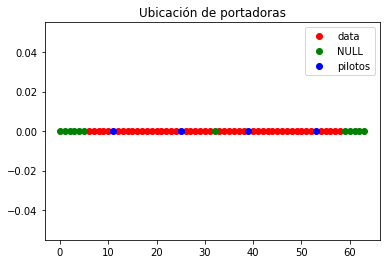

In [98]:
plt.figure()
plt.title("Ubicación de portadoras")
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')
plt.plot(NullCarrier,np.zeros_like(NullCarrier),'go',label='NULL')
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilotos')
plt.legend()

## Mapeo
Vamos a implementar el mapeo de 16QAM de la norma. Los demas esquemas de modulacion pueden hacerse de manera similar.
Al valor del simbolo se lo afecta por una constante de normalizacion que para el caso de 16QAM es Raiz(10)


<img src=".\mapeo.png">

In [99]:
mu = 4  #(16QAM) 4 bits por simbolo
kmod=1/np.sqrt(10)  # el valor del kmod esta en la tabla 17.6

# Numero de bits por simbolo OFDM se calcula como el numero de portadoras de datos multiplicado por el numero de bits por simbolo

payloadBits_per_OFDM = len(dataCarriers)*mu 

mapping_table = {
    (0,0,0,0) : (-3-3j)*kmod,
    (0,0,0,1) : (-3-1j)*kmod,
    (0,0,1,0) : (-3+3j)*kmod,
    (0,0,1,1) : (-3+1j)*kmod,
    (0,1,0,0) : (-1-3j)*kmod,
    (0,1,0,1) : (-1-1j)*kmod,
    (0,1,1,0) : (-1+3j)*kmod,
    (0,1,1,1) : (-1+1j)*kmod,
    (1,0,0,0) :  (3-3j)*kmod,
    (1,0,0,1) :  (3-1j)*kmod,
    (1,0,1,0) :  (3+3j)*kmod,
    (1,0,1,1) :  (3+1j)*kmod,
    (1,1,0,0) :  (1-3j)*kmod,
    (1,1,0,1) :  (1-1j)*kmod,
    (1,1,1,0) :  (1+3j)*kmod,
    (1,1,1,1) :  (1+1j)*kmod
}


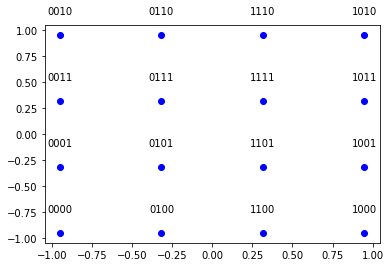

In [100]:
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

Es interesante observar que la asignacion de palabras de codigos a simbolos no es casual. Si observamos vemos que un solo  bit cambia entre simbolos adyacentes mientras que el resto permanece constante, es un mapeo tipo Gray. Esto minimiza el error de bits, en caso de una falla en la deteccion del simbolo solo tendremos 1 bit equivocado.

## Generamos los bits de datos

El estandar 802.11a/g soporta desde modulacion BPSK hasta 64QAM y posteriormente 802.11n alcanzo hasta 256QAM.La duración total del simbolo es de 4us con un 20% de intervalo de guarda. La longitud de la IFFT es de 64 portadoras, recordando que de las 64, 12 son suprimidas (NULL Carriers) y 4 son pilotos. 
    
    64-12-4=48 portadoras utiles
    
    La tasa de símbolos es 48/4us= 12 MSimbolos/s
    
    Para BPSK 1bit/Simbolo = 12Mbps
    Para QPSK 2bit/Simbolo = 24Mbps
    Para 16QAM 4bit/Simbolo = 48Mbps
    Para 64QAM 6bit/Simbolo = 72Mbps

Esta es la tasa bruta de bits, no la util, ya que hay que tener en cuenta ademas la codificación convolucional que se utilizo.
       



<img src=".\ejemplo_modulacion.png">


In [101]:
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
print(bits)
print("Cada simbolo lleva %s" %len(bits))

[0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1
 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0
 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0
 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1
 0 0 1 1 0 0 1]
Cada simbolo lleva 192


## Conversión Serie Paralelo

La clave de los sistemas multiportadoras como OFDM es dividir el stream de datos por el numero de portadoras de datos que el sistema tiene. De esta forma, la duracion de cada simbolo aumenta de manera proporcional al numero de portadoras de datos que tengamos. Para programar esto hacemos un "reshape" del stream. Vamos a hacer grupos de 4 bits (debido al mapeo usado de 16QAM) por un numero igual al de las portadoras de dato.

In [102]:
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))
bits_SP = SP(bits)
print ("Primeros bits reagrupados")
print (bits_SP[:5,:])
print("Agrupamos los bist de a {} segun la modulacion y de a {} segun el numero de portadoras de dato".format(np.shape(bits_SP)[1],np.shape(bits_SP)[0]))

Primeros bits reagrupados
[[0 1 0 1]
 [0 1 1 0]
 [0 1 0 1]
 [0 0 0 1]
 [1 0 1 0]]
Agrupamos los bist de a 4 segun la modulacion y de a 48 segun el numero de portadoras de dato


First 5 QAM symbols and bits:
[[0 1 0 1]
 [0 1 1 0]
 [0 1 0 1]
 [0 0 0 1]
 [1 0 1 0]]
[-0.31622777-0.31622777j -0.31622777+0.9486833j  -0.31622777-0.31622777j
 -0.9486833 -0.31622777j  0.9486833 +0.9486833j ]


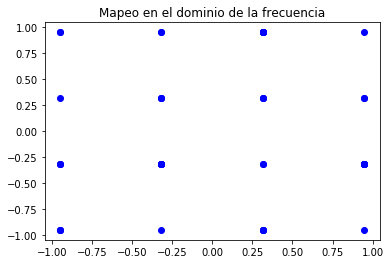

In [103]:
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])

QAM = Mapping(bits_SP)
print ("First 5 QAM symbols and bits:")
print (bits_SP[:5,:])
print (QAM[:5])
plt.figure()
plt.title("Mapeo en el dominio de la frecuencia")
plt.plot(QAM.real,QAM.imag,'bo')

## Generación del simbolo OFDM

Portadoras en el dominio de la frecuencia:  64


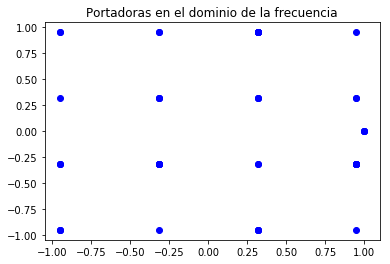

In [104]:
def OFDM_symbol(QAM_payload,Sym_count):
    symbol = np.zeros(K, dtype=complex) # cero en todas las portados
    symbol[pilotCarriers] = pilotValue[Sym_count]  # cargo el valor del piloto siguiendo la secuencia 
    symbol[dataCarriers] = QAM_payload  # ubico los datos en las portadoras de dato
    return symbol
OFDM_data = OFDM_symbol(QAM,0)   # el "0" indica que es el primer simbolo que voy a transmitir..
plt.figure("Portadoras en el dominio de la frecuencia")
plt.title("Portadoras en el dominio de la frecuencia")
print ("Portadoras en el dominio de la frecuencia: ", len(OFDM_data))
plt.plot(OFDM_data.real[dataCarriers],OFDM_data.imag[dataCarriers],'bo')
plt.plot(OFDM_data.real[pilotCarriers],OFDM_data.imag[pilotCarriers],'bo')

Nota: cuando graficamos, nos encargamos de poner unicamente las portadoras de dato, sino van a aparecer las portadoras pilotos y las portadoras Null 

Duracion del simbolo activo 3.2us


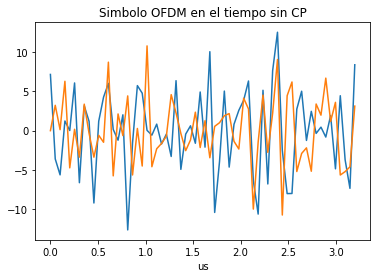

In [105]:
def IDFT(OFDM_data):
    return np.fft.fft(OFDM_data)
OFDM_time = IDFT(OFDM_data)

plt.figure("simbolo OFDM en el tiempo sin CP")
plt.title("Simbolo OFDM en el tiempo sin CP")
plt.xlabel("us")
plt.plot(t,OFDM_time.real,t,OFDM_time.imag)
print("Duracion del simbolo activo {}us".format(t[-1]))

In [106]:
len(t)

64

# PPDU

#### PLCP = physical layer convergence procedure
#### PPDU = PLCP protocol data unit

La norma 802.11 define una serie de mecanismos que brindan distintos servicios. Convierte los paquetes provenientes del nivel MAC en PPDU (PLCP Protocol Data Unit). Esto mediante la agregación de un PLCP preamble y un PLCP header; El preambulo del PLCP es una serie de 12 simbolos OFDM que le sirven al receptor para detectar señal, estimar el canal, estimar la frecuencia de la trasnmision.
El encabezado del PLCP le informara al receptor la cantidad de datos que van a ser transmitidos, y la modulacion que se utilizara 

<img src=".\frame.png">


## Agregado del prefijo Cíclico

Del simbolo total, el prefijo ciclico es 0,8us y el "simbolo activo" es 3,2us esto representa un intervalo de guarda igual a 1/4

numero de muestras en el tiempo despues del CP: 80


C:\Users\Telecomu\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


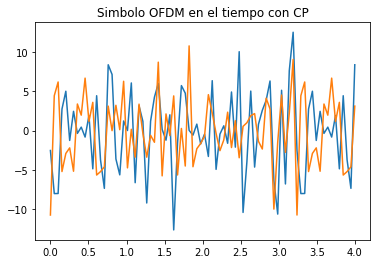

Duracion del simbolo con el prefijo 4.0us


In [107]:
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # las ultimas muestas de CP ...
    return np.hstack([cp, OFDM_time])  # ... las agrega al principio

OFDM_withCP = addCP(OFDM_time)

print ("numero de muestras en el tiempo despues del CP:", len(OFDM_withCP))
t=np.linspace(0,ts*K*1.25,K*1.25)  # nuestro futuro eje de tiempos

plt.figure("simbolo OFDM en el tiempo con CP")
plt.title("Simbolo OFDM en el tiempo con CP")
plt.plot(t,OFDM_withCP.real,t,OFDM_withCP.imag)

plt.show()

print("Duracion del simbolo con el prefijo {}us".format(t[-1]))

In [108]:
len(t)

80

## Pulse Shapping
<img src=".\shaping.png">


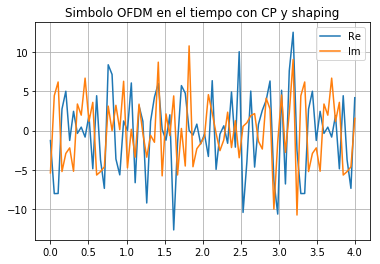

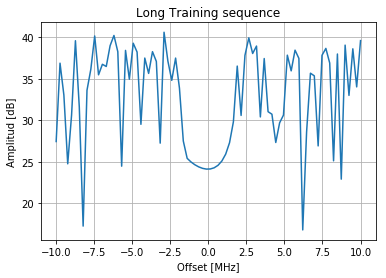

In [109]:
def shaping(a):
    mask=np.ones(len(a))
    mask[0]=0.5
    mask[-1]=0.5
    return a*mask

OFDM_withCP_Shape = shaping(OFDM_withCP)

plt.title("Simbolo OFDM en el tiempo con CP y shaping")
plt.plot(t,OFDM_withCP_Shape.real,label='Re')
plt.plot(t,OFDM_withCP_Shape.imag,label='Im')
plt.legend(fontsize=10)
plt.grid()
plt.show()

fcia=np.linspace(-fs/2,fs/2,len(OFDM_withCP_Shape))
w=signal.blackmanharris(len(OFDM_withCP_Shape))
plt.plot(fcia,20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(OFDM_withCP_Shape)))))

plt.title("Long Training sequence")
plt.xlabel("Offset [MHz]")
plt.ylabel("Amplitud [dB]")
plt.grid(True)

## Training sequence

WiFi antes de mandar los datos hace varias cosas, sobre todo teniendo en cunta que el medio fisico es el un canal wireless con fading selectivo en frecuencia. Ademas debe implementar Carrier-sense multiple access with collision avoidance (CSMA/CA). Para todo esto el estandar contempla 2 entramientos

### short training
Dura aproximadamente 8us, consiste en 161 muestras de IFFT construidas a partir de una secuencia dada en la norma en la expresión 17.6.
Permite al receptor detectar el canal ocupado y apartir del nivel con que se recive, ajustar niveles de AGC y sincrocización y ajuste de frecuencia.

<img src=".\short.png">

In [110]:
# de la norma expresión 17.6, copio directamente el valor del vector
short_preamble=[0,0,0,0,0,0,0,0,1+1j,0,0,0,-1-1j,0,0,0,1+1j,0,0,0,-1-1j,0,0,0,-1-1j,0,0,0,1+1j,0,0,0,0,0,0,0,-1-1j,0,0,0,-1-1j,0,0,0,1+1j,0,0,0,1+1j,0,0,0,1+1j,0,0,0,1+1j,0,0,0,0,0,0,0]

short_preamble=np.asanyarray(short_preamble)*np.sqrt(13/6)
short_preamble=np.fft.fftshift(short_preamble)   ## recordar el mapeo de las portadoras en la IFFT!!
# print("Valores antes de la IFFT \n")
# print(np.round(short_preamble.reshape(4,16),1).T)
short_preamble=np.fft.ifft(short_preamble)
short_preamble_shape=shaping(short_preamble)
print("\nValores despues de la IFFT \n")
print(np.round(short_preamble_shape.reshape(16,4),3)) 
#plt.plot(t[:64],short_preamble)
print("tiempo {}".format(t[64]))



Valores despues de la IFFT 

[[ 0.023+0.023j -0.132+0.002j -0.013-0.079j  0.143-0.013j]
 [ 0.092+0.j     0.143-0.013j -0.013-0.079j -0.132+0.002j]
 [ 0.046+0.046j  0.002-0.132j -0.079-0.013j -0.013+0.143j]
 [ 0.   +0.092j -0.013+0.143j -0.079-0.013j  0.002-0.132j]
 [ 0.046+0.046j -0.132+0.002j -0.013-0.079j  0.143-0.013j]
 [ 0.092+0.j     0.143-0.013j -0.013-0.079j -0.132+0.002j]
 [ 0.046+0.046j  0.002-0.132j -0.079-0.013j -0.013+0.143j]
 [ 0.   +0.092j -0.013+0.143j -0.079-0.013j  0.002-0.132j]
 [ 0.046+0.046j -0.132+0.002j -0.013-0.079j  0.143-0.013j]
 [ 0.092+0.j     0.143-0.013j -0.013-0.079j -0.132+0.002j]
 [ 0.046+0.046j  0.002-0.132j -0.079-0.013j -0.013+0.143j]
 [ 0.   +0.092j -0.013+0.143j -0.079-0.013j  0.002-0.132j]
 [ 0.046+0.046j -0.132+0.002j -0.013-0.079j  0.143-0.013j]
 [ 0.092+0.j     0.143-0.013j -0.013-0.079j -0.132+0.002j]
 [ 0.046+0.046j  0.002-0.132j -0.079-0.013j -0.013+0.143j]
 [ 0.   +0.092j -0.013+0.143j -0.079-0.013j  0.001-0.066j]]
tiempo 3.240506329113924


<img src=".\short-tr.png">


El período único de la secuencia corta de entrenamiento se extiende periódicamente para 161 muestras (aproximadamente 8 μs), y luego multiplicado por la función de ventana:

In [111]:
short_preamble=np.append(short_preamble,short_preamble)
short_preamble=np.append(short_preamble,short_preamble[0:33])
#len(short_preamble)
short_preamble_shape=shaping(short_preamble)
print(short_preamble_shape)

[ 0.02299938+0.02299938j -0.13244372+0.00233959j -0.01347272-0.07852479j
  0.14275529-0.01265117j  0.09199751+0.j          0.14275529-0.01265117j
 -0.01347272-0.07852479j -0.13244372+0.00233959j  0.04599875+0.04599875j
  0.00233959-0.13244372j -0.07852479-0.01347272j -0.01265117+0.14275529j
  0.        +0.09199751j -0.01265117+0.14275529j -0.07852479-0.01347272j
  0.00233959-0.13244372j  0.04599875+0.04599875j -0.13244372+0.00233959j
 -0.01347272-0.07852479j  0.14275529-0.01265117j  0.09199751+0.j
  0.14275529-0.01265117j -0.01347272-0.07852479j -0.13244372+0.00233959j
  0.04599875+0.04599875j  0.00233959-0.13244372j -0.07852479-0.01347272j
 -0.01265117+0.14275529j  0.        +0.09199751j -0.01265117+0.14275529j
 -0.07852479-0.01347272j  0.00233959-0.13244372j  0.04599875+0.04599875j
 -0.13244372+0.00233959j -0.01347272-0.07852479j  0.14275529-0.01265117j
  0.09199751+0.j          0.14275529-0.01265117j -0.01347272-0.07852479j
 -0.13244372+0.00233959j  0.04599875+0.04599875j  0.0023395

La duración de la secuencia corta es de 8.05


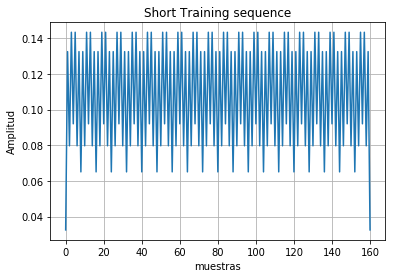

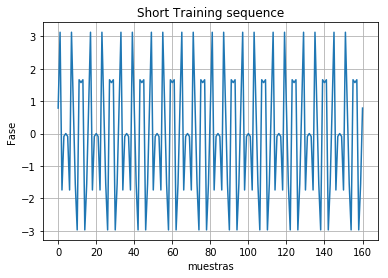

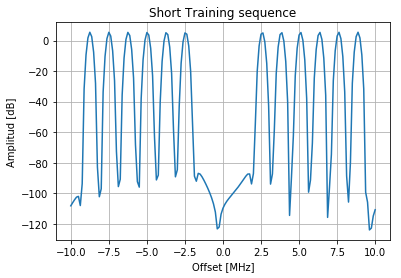

In [112]:
print("La duración de la secuencia corta es de {}".format(ts*len(short_preamble_shape)))
plt.plot(np.abs(short_preamble_shape))
plt.title("Short Training sequence")
plt.xlabel("muestras")
plt.ylabel("Amplitud")
plt.grid(True)
plt.figure()

plt.plot(np.angle(short_preamble_shape))
plt.title("Short Training sequence")
plt.xlabel("muestras")
plt.ylabel("Fase")
plt.grid(True)
plt.figure()

fcia=np.linspace(-fs/2,fs/2,len(short_preamble_shape))
w=signal.blackmanharris(len(short_preamble_shape))
plt.plot(fcia,20*np.log10(np.abs(np.fft.fft(short_preamble*w))))

plt.title("Short Training sequence")
plt.xlabel("Offset [MHz]")
plt.ylabel("Amplitud [dB]")
plt.grid(True)

METHOD OF SYNCHRONIZATION USING IEEE 802.1 la OFDM
TRAINING STRUCTURE FOR INDOOR WIRELESS
APPLICATIONS
by
Cheuk Kwan Lui
B.S.E.E., California State University, Fresno, 1991 

<img src=".\short-training.png">

## Training sequence - Long training

Su funcion es la estimacion fina del canal y de la frecuencia del transmisor

<img src=".\long.png">

In [113]:
long_preamble=[0,0,0,0,0,0,1,1,-1,-1,1,1,-1,1,-1,1,1,1,1,1,1,-1,-1,1,1,-1,1,-1,1,1,1,1,0,1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,-1,-1,1,1,-1,1,1,-1,1,-1,1,1,1,1,0,0,0,0,0]
#print(len(long_preamble))
long_preamble=np.asanyarray(long_preamble)
#print(long_preamble)
long_preamble=np.fft.fftshift(long_preamble)
#print(long_preamble)
long_preamble=np.fft.ifft(long_preamble)
cp = long_preamble[-K//2:]               # las ultimas muestas de CP ...
print(long_preamble)
long_preamble=np.append(long_preamble,long_preamble)
long_preamble=np.hstack([cp, long_preamble])
long_preamble=shaping(long_preamble)

[ 0.1875    +0.j         -0.01121782-0.08967559j  0.01087846-0.1231168j
  0.11419345+0.05681448j  0.04320886+0.04998301j  0.03384042-0.07034519j
 -0.12709007-0.08405173j -0.00766643-0.11226749j  0.09754126+0.00536165j
  0.02268819-0.00202025j  0.01294784-0.14387588j -0.11082145-0.03001824j
  0.00237876-0.03643471j  0.0413072 -0.04092242j  0.00638803+0.14869848j
  0.12533566+0.02655395j  0.03125   -0.0625j      0.04301451+0.06769461j
 -0.02833511+0.05125745j -0.14862418+0.09121065j  0.06012124+0.07025947j
  0.09554027-0.00323961j -0.04835124+0.11015736j -0.08710467-0.01570735j
 -0.03504126-0.18213835j -0.09123747-0.01046965j -0.13928322+0.00836986j
  0.04909027-0.09140199j  0.01929114+0.03167718j -0.07452599+0.14111213j
  0.06284531+0.11783052j  0.00618802+0.06695001j -0.125     +0.j
  0.00618802-0.06695001j  0.06284531-0.11783052j -0.07452599-0.14111213j
  0.01929114-0.03167718j  0.04909027+0.09140199j -0.13928322-0.00836986j
 -0.09123747+0.01046965j -0.03504126+0.18213835j -0.08710467

In [114]:
print("La duracion de la secuencia de entrenamiento larga es {} us".format(len((long_preamble))*ts))


La duracion de la secuencia de entrenamiento larga es 8.0 us


La duración de la secuencia corta es de 8.0


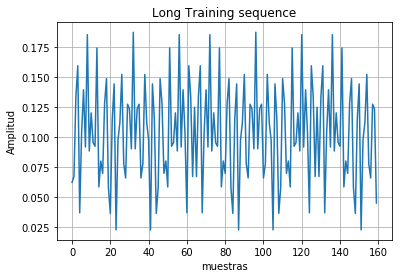

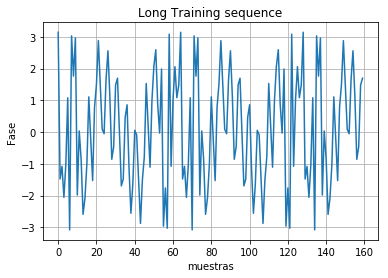

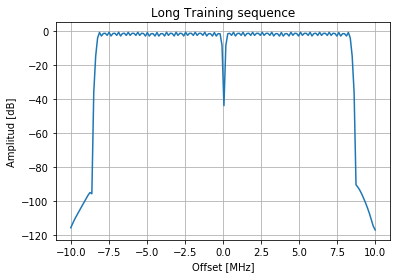

In [115]:
print("La duración de la secuencia corta es de {}".format(ts*len(long_preamble)))
plt.plot(np.abs(long_preamble))
plt.title("Long Training sequence")
plt.xlabel("muestras")
plt.ylabel("Amplitud")
plt.grid(True)
plt.figure()

plt.plot(np.angle(long_preamble))
plt.title("Long Training sequence")
plt.xlabel("muestras")
plt.ylabel("Fase")
plt.grid(True)
plt.figure()

fcia=np.linspace(-fs/2,fs/2,len(long_preamble))
w=signal.blackmanharris(len(long_preamble))
plt.plot(fcia,20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(long_preamble*w)))))

plt.title("Long Training sequence")
plt.xlabel("Offset [MHz]")
plt.ylabel("Amplitud [dB]")
plt.grid(True)

METHOD OF SYNCHRONIZATION USING IEEE 802.1 la OFDM
TRAINING STRUCTURE FOR INDOOR WIRELESS
APPLICATIONS
by
Cheuk Kwan Lui
B.S.E.E., California State University, Fresno, 1991 

<img src=".\long-training.png">

Ya tenemos las dos secuencias armadas segun indica la norma, ahora las unimos y la tenemos preparada para trasnmitir antes de cada paquete de  datos


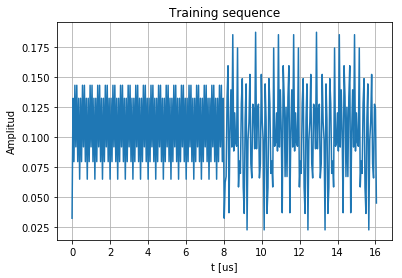

In [116]:
training_seq=np.append(short_preamble_shape,long_preamble)

plt.plot(np.linspace(0,ts*len(training_seq),len(training_seq)),np.abs(training_seq))
plt.title("Training sequence")
plt.xlabel("t [us]")
plt.ylabel("Amplitud")
plt.grid(True)

Lo que se veria en un analizador de espectro en span0


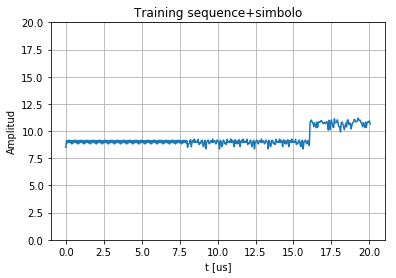

In [117]:
training_and_symbol=np.append(training_seq,OFDM_withCP_Shape)

plt.plot(np.linspace(0,ts*len(training_and_symbol),len(training_and_symbol)),10+np.log10(np.abs(training_and_symbol)))
plt.title("Training sequence+simbolo")
plt.xlabel("t [us]")
plt.ylabel("Amplitud")
plt.ylim((0,20))
plt.grid(True)

print("Lo que se veria en un analizador de espectro en span0")

<img src=".\frame1.png">
https://www.wlanpedia.org/tech/phy/ofdm-in-wlan/

In [118]:
N_of_sym=50
frame=np.empty(0)
frame_shapped=np.empty(0)
for sym in range(N_of_sym):
    bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
    bits_SP = SP(bits)
    QAM = Mapping(bits_SP)
    OFDM_data = OFDM_symbol(QAM,sym)
    OFDM_time = IDFT(OFDM_data)
    OFDM_withCP = addCP(OFDM_time)
    OFDM_withCP_Shape=shaping(OFDM_withCP)
    OFDM_withCP_Shape=OFDM_withCP
    frame_shapped=np.append(frame_shapped,OFDM_withCP_Shape,axis=0)
    #frame=np.append(frame,OFDM_withCP,axis=0)

frame=frame_shapped
frame=np.append(training_seq,frame)

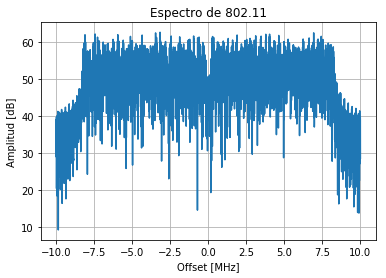

In [119]:
fcia=np.linspace(-fs/2,fs/2,len(frame))
#plt.plot(fcia,20*np.log10(np.abs(np.fft.fft(frame))),fcia,20*np.log10(np.abs(np.fft.fft(frame_shapped))))
#plt.plot(fcia,20*np.log10(np.abs(np.fft.fft(frame_shapped))))
plt.plot(fcia,20*np.log10(np.abs(np.fft.fft(frame))))

plt.title("Espectro de 802.11")
plt.xlabel("Offset [MHz]")
plt.ylabel("Amplitud [dB]")
plt.grid(True)


## Llegamos a obtener el espectro de 802.11agn

<img src=".\802.11.jpg">

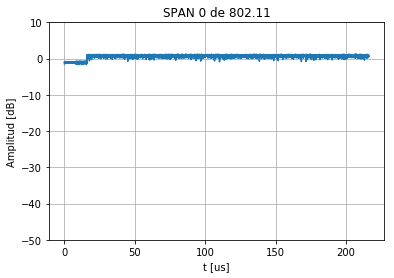

In [131]:
plt.plot(np.linspace(0,ts*len(frame),len(frame)),np.log10(np.abs(frame)))
plt.title("SPAN 0 de 802.11")
plt.xlabel("t [us]")
plt.ylabel("Amplitud [dB]")
plt.ylim((-50,10))
plt.grid(True)

<img src=".\802.11-0span.jpg">

## Hacia la demodulacion

In [121]:
def removeCP(frame,N_of_sym):
    frame=np.reshape(frame,(N_of_sym,80))
    return frame[:,CP:(CP+K)]
    
OFDM_RX_noCP = removeCP(frame[len(training_seq):],N_of_sym)


In [122]:
print(np.shape(OFDM_RX_noCP))


(50, 64)


In [123]:
# la señal es demodulada ahora usando la FFT

def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)
print(np.shape(OFDM_demod))


(50, 64)


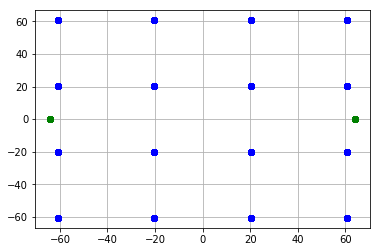

In [124]:
def get_payload(equalized):
    return OFDM_demod[dataCarriers]

for simbolo in range(N_of_sym):
    plt.plot(OFDM_demod.real[simbolo][dataCarriers], OFDM_demod.imag[simbolo][dataCarriers], 'bo');
    plt.plot(OFDM_demod.real[simbolo][pilotCarriers], OFDM_demod.imag[simbolo][pilotCarriers], 'go');

plt.grid()
plt.show()

## Llegamos!
al final podemos entender de donde sale toda la info que nos da el instrumento y que procesamiento hizo para obtenerla

<img src=".\rodhe1.png">

# La PAR

Es la relacion entre la potencia pico y la potencia media. Es un parametro que caracteriza la naturaleza de la señal. Se tiene en cuenta tanto para el diseño de los amplificadores como para la medición de la señal.
En el caso de los amplificadores, estos deben tener una zona lineal lo suficientemente amplia para no distorsionar los picos de señal. Para el caso de la medicion, el detector seleccionado en el intrumento (analizador deespectro)

La PAR se decine como

$PAR = \frac{MAX[x(t).x(t)*]}{E[x(t).x(t)*]}$

primero vemos como da la par para algunas modulaciones lineales

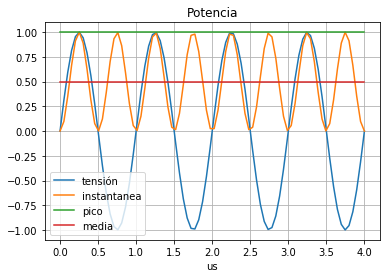

In [125]:
triste_seno=np.sin(2*np.pi*t)
plt.plot(t,triste_seno,label='tensión')

plt.plot(t,(triste_seno*np.conj(triste_seno)).real,label='instantanea')
plt.plot(t,np.ones(len(triste_seno))*np.max(triste_seno*np.conj(triste_seno)).real,label='pico')
plt.plot(t,np.ones(len(triste_seno))*np.mean(triste_seno*np.conj(triste_seno)).real,label='media')
plt.title("Potencia")
plt.xlabel("us")
plt.legend(fontsize=10)
plt.grid()
plt.show()

potencia_seno=triste_seno*np.conj(triste_seno)

In [126]:
PAR=(np.max(triste_seno*np.conj(triste_seno))/np.mean(triste_seno*np.conj(triste_seno))).real
print("La relacion entre la potencia pico y la potencia media para una senoidal es %.2f veces %.2f dB"%(PAR,10*np.log10(PAR)))

La relacion entre la potencia pico y la potencia media para una senoidal es 2.02 veces 3.06 dB


# OFDM y la PAR o PAPR

Se demuestra en otro notebook la ventaja de OFDM en canales dispersivos, su inmunidad frente a la propagacion multiple trayectoria, pero analizaremos la caracteristica de la señal y relacion entre potencia pico y potencia promedio o average

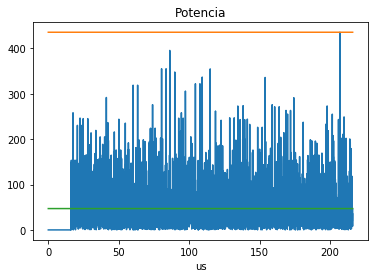

In [127]:
t_frame=np.linspace(0,len(frame)*ts,len(frame))

plt.plot(t_frame,(frame*np.conj(frame)).real,label='instantanea')
plt.plot(t_frame,np.ones(len(frame))*np.max(frame*np.conj(frame)).real,label='pico')
plt.plot(t_frame,np.ones(len(frame))*np.mean(frame*np.conj(frame)).real,label='media')
plt.title("Potencia")
plt.xlabel("us")
plt.show()

potencia_frame=frame*np.conj(frame)

In [128]:
PAR=(np.max(frame*np.conj(frame))/np.mean(frame*np.conj(frame))).real
print("La relacion entre la potencia pico y la potencia media es %.2f veces %.2f dB"%(PAR,10*np.log10(PAR)))

La relacion entre la potencia pico y la potencia media es 9.26 veces 9.67 dB


Puede demostrarse que la PAR crece con el numero de portadoras OFDM.

## CCDF (power complementary cumulative distribution function)

La curva CCDF muestra cuánto tiempo pasa la señal en o por encima de un nivel de potencia dado, en dB en relación con la potencia media.

<img src=".\CCDF.png">

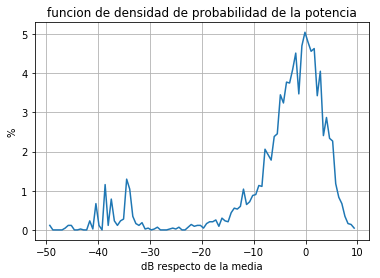

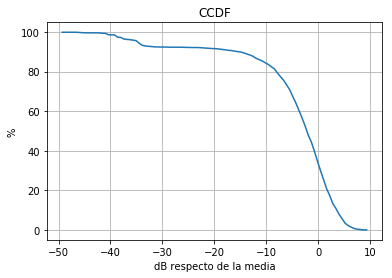

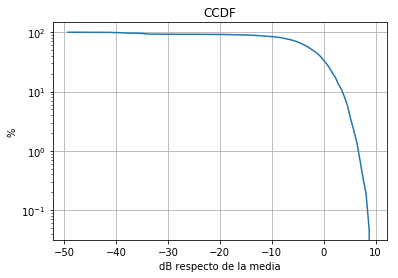

In [129]:
def CCDF(potencia):
    h = np.histogram(potencia, 100)
    CCDF=1-h[0].cumsum()
    return (h[1][:-1]+h[1][1:])/2, (CCDF/len(potencia)+1)*100

def CCDFdB(potencia):
    dB=10*np.log10(potencia.real)-10*np.log10(np.mean(potencia.real))  # 0dB sera respecto de la potencia media   
    h = np.histogram(dB, 100)
    H = np.cumsum(h[0])/len(potencia)
    CH=1-H
    return (h[1][:-1]+h[1][1:])/2,CH*100


plt.figure()
dB=10*np.log10(potencia_frame.real)-10*np.log10(np.mean(potencia_frame.real))  # 0dB sera respecto de la potencia media   
#plt.plot(dB)
#plt.figure()
h = np.histogram(dB, 100)

plt.plot((h[1][:-1]+h[1][1:])/2,(h[0]/len(dB))*100)
plt.title("funcion de densidad de probabilidad de la potencia")
plt.xlabel("dB respecto de la media")
plt.ylabel("%")
plt.grid(True)

plt.figure()
x,y=CCDFdB((potencia_frame.real))
plt.plot(x,y)
plt.title("CCDF")
plt.xlabel("dB respecto de la media")
plt.ylabel("%")
plt.grid(True)

fig, ax = plt.subplots()

ax.semilogy(x,y)
ax.grid()
ax.set_title("CCDF")
ax.set_xlabel("dB respecto de la media")
ax.set_ylabel("%")
plt.show()

<img src=".\ccdf_AE1.png">